---
layout: page
title: Interest Rates
---

In [55]:
""" import library and package dependencies """
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pytz
from collections import namedtuple
from urllib.parse import quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from IPython.display import display, Markdown

from data_loader import load_csv_data, get_last_publish_date
from chart_format import StandardChart, PercentileChart

The Housing Loan Lending Rates are set by the Reserve Bank of Australia and published monthly within five business days after month end.

In [56]:
""" Load data 
RBA monthly home lending rates from 1959
https://www.rba.gov.au/statistics/tables/frequency-statistical-releases.html
Rates are published around 11:30am 5 business days after the end of the month
"""
publish_date = pd.Timestamp.now() + pd.offsets.MonthBegin(-1) + pd.offsets.BDay(5)

csv_url = 'https://www.rba.gov.au/statistics/tables/csv/f5-data.csv'
local_file = '../data/f5-data.csv'

# First 10 rows are descriptive header rows
skip_rows = 10

df = load_csv_data(local_file, csv_url, publish_date, skip_rows)

In [57]:
# Data Transformation
df.dropna(subset=['Series ID'], inplace=True)

""" Data Transformation """
# FILRHLBVS = Financial Interest; Lending rates; Housing loans; Banks; Variable; Standard; Owner-occupier
data_column = 'FILRHLBVS'

# Series ID dates are in the format 'Jan-1959' %b-%Y
df['Date'] = df['Series ID'].apply(lambda d: pd.to_datetime(d, format='%b-%Y') + pd.offsets.MonthEnd(1))
df.set_index('Date', inplace=True)

last_index = df[data_column].last_valid_index()
# only include rows up to the last_index (drop the NaN rows at end of file)
df = df.loc[:last_index]


Australian interest rates ramped up from 6% in 1970 to a peak 17% in 1990 before dropping sharply back down to 10% in 1992.

Interest rates remained highly volatile but trended down to 5% in 2020 before spiking back over 8% in 2023.

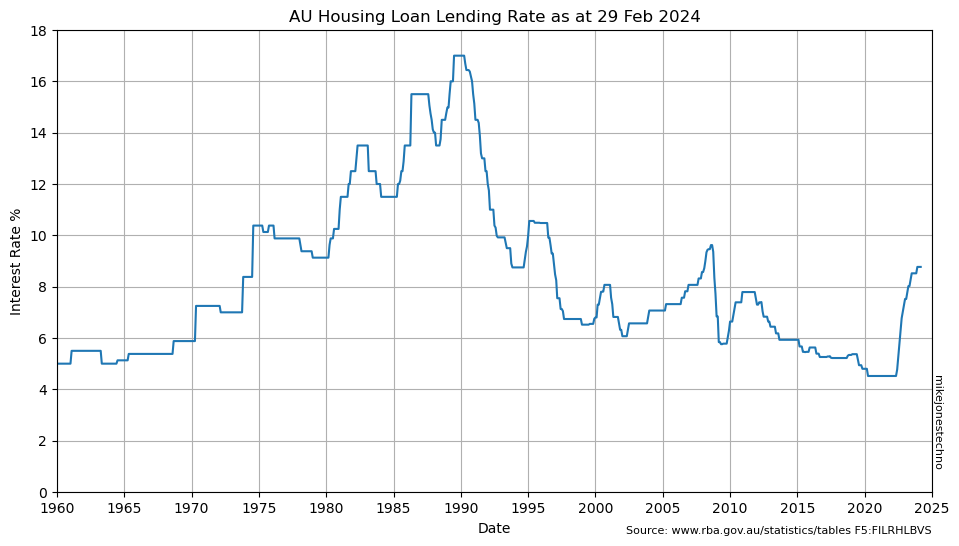

In [58]:
""" Show simple chart """

chart_params = {
    'chart_title': 'AU Housing Loan Lending Rate as at ' + last_index.strftime('%d %b %Y'), 
    'chart_source': 'Source: www.rba.gov.au/statistics/tables F5:' + data_column, 
    'y_label': 'Interest Rate %', 
    'y_ticks': 2,
    'x_label': 'Date', 
    'x_ticks': 5,
    'start_year': 1960,
    'data_column': data_column
}

standard_chart = StandardChart(**chart_params)
plt, colors = standard_chart.base_chart(df)

plt.plot(df.index, df[data_column], color=colors[0]['color'])

plt.show()

In [59]:
""" Calculate median 50th and lower, upper percentiles over multiple years """
periods_per_year = 12
multi_year = 10
multi_year_extended = 3

multi_years = [10, 20, 30]

# Define the percentiles and window sizes
Percentiles = namedtuple('Percentiles', ['lower', 'median', 'upper'])
percentiles = Percentiles(25, 50, 75)

window_periods = [
    periods_per_year,
    periods_per_year * multi_years[0],
    periods_per_year * multi_years[1],
    periods_per_year * multi_years[2]
]

def add_percentiles(df, column, window, prefix):
    """Calculate and add percentiles to the DataFrame for a given window size."""
    for percentile_name, percentile in zip(percentiles._fields, percentiles):
        df[f'{prefix}_{percentile_name}'] = df[column].rolling(window=window).quantile(percentile/100)

# Calculate and add the percentiles for each window size
for window in window_periods:
    years = window // periods_per_year
    name = f'rolling_{years}_years'
    add_percentiles(df, data_column, window, name)


In [60]:
""" Create a markdown data table of the multi year percentiles to reuse in other notebooks """

# Create the header rows of the table
table = "| Years |   " + " |   ".join(f'{str(percentile)}' for percentile in percentiles) + " |\n"
table += "|-------" + "|-----:" * len(Percentiles._fields) + "|\n"

# Add the percentile values for each window period
for window in window_periods:
    years = window // periods_per_year
    name = f'rolling_{years}_years'
    table += f"| {str(years).ljust(5)} | " + " | ".join("{:,.2f}".format(df[f'{name}_{percentile_name}'].iloc[-1]) for percentile_name in Percentiles._fields) + " |\n"

In [61]:
with open('../data/interest_rate_percentiles.md', 'w') as f:
    f.write(table)
    f.close()

In [62]:
display(Markdown(f"""
Calculating the {percentiles[0]}th and {percentiles[2]}th percentile over a multi year time horizon helps smooth out the anomolies and visualize the {Percentiles._fields[0]} and {Percentiles._fields[2]} long term trends.
"""))


Calculating the 25th and 75th percentile over a multi year time horizon helps smooth out the anomolies and visualize the lower and upper long term trends.


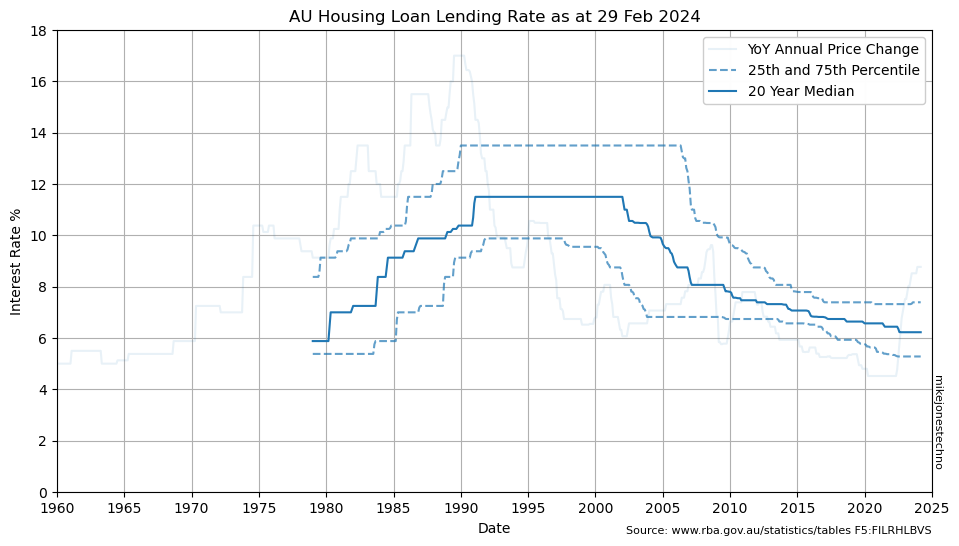

In [63]:
chart_params['color_index'] = 0
chart_params['legend_location'] = 'best'
percentile_chart = PercentileChart(percentiles, multi_years[1], **chart_params)
plt = percentile_chart.plot_percentiles(df) 
plt.show()

In [64]:
# Replace headings for percentile column headings
headings = table.split('\n')[0].split('|')[2:-1]
updated_headings = [ heading.strip() + 'th percentile' for heading in headings]
updated_headings_row = '| Years | ' + ' | '.join(updated_headings) + ' |'
show_table = table.replace(table.split('\n')[0], updated_headings_row, 1)

display(Markdown(f"""
Over the last {multi_years[0]} years the {Percentiles._fields[1]} ({percentiles[1]}th percetile) change is { "{:,.2f}".format(df[f'rolling_{multi_years[0]}_years_{Percentiles._fields[1]}'].iloc[-1])  }%.

Over the last {multi_years[-1]} years the {Percentiles._fields[1]} ({percentiles[1]}th percetile) change is { "{:,.2f}".format(df[f'rolling_{multi_years[-1]}_years_{Percentiles._fields[1]}'].iloc[-1])  }%.

{show_table}
"""))


Over the last 10 years the median (50th percetile) change is 5.28%.

Over the last 30 years the median (50th percetile) change is 6.74%.

| Years | 25th percentile | 50th percentile | 75th percentile |
|-------|-----:|-----:|-----:|
| 1     | 8.46 | 8.52 | 8.77 |
| 10    | 4.80 | 5.28 | 5.81 |
| 20    | 5.28 | 6.22 | 7.39 |
| 30    | 5.76 | 6.74 | 7.79 |



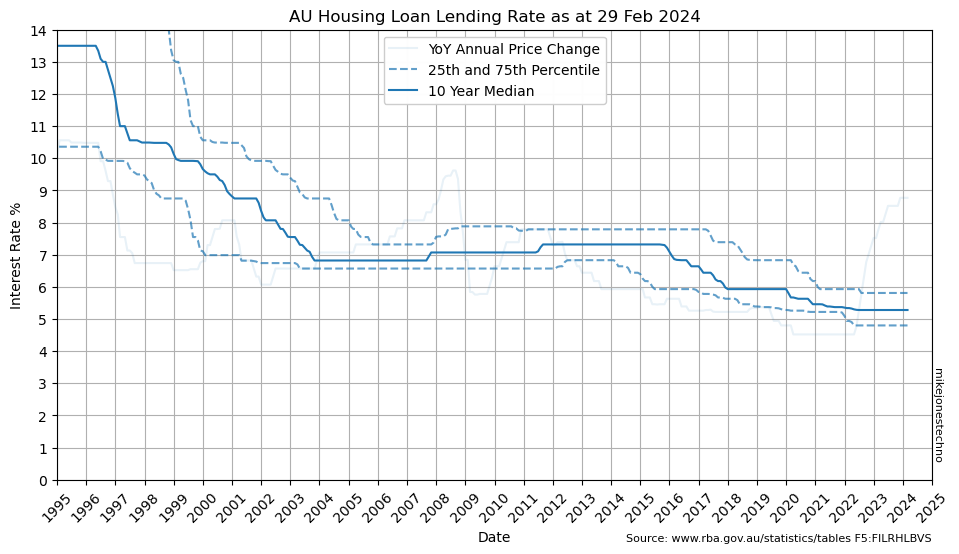

In [66]:
""" Change chart variables to plot from 1995"""

chart_params['start_year'] = 1995
chart_params['end_year'] = 2025 # set end year to multiple of old x_ticks before we change to 1 year ticks.
chart_params['y_ticks'] = 1
chart_params['x_ticks'] = 1
chart_params['top_limit'] = 14
chart_params['legend_location'] = 'upper center'

percentile_chart = PercentileChart(percentiles, multi_years[0], **chart_params)
plt = percentile_chart.plot_percentiles(df)
plt.show()

The chart shows interst rates have trended down from 7% to below 6%.

> ℹ The data suggests reasonable confidence using a baseline interest rates around 6% with some uncertainty or risk that interest rates could peak higher.